**Kernel**
- [TimeSeries Analysis 📈 A Complete Guide 📚](https://www.kaggle.com/andreshg/timeseries-analysis-a-complete-guide)

**Dataset**
- [Acea Smart Water Analytics](https://www.kaggle.com/c/acea-water-prediction)

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from colorama import Fore

from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

import warnings
warnings.filterwarnings('ignore')

np.random.seed(7)

**Table of Content**

- 1. Data visualization 📊
- 2. Data Preprocessing ⚙️
    - 2.1 Handle Missings
    - 2.2 Smoothing data / Resampling
    - 2.3 Stationarity
        - 2.3.1 Augmented Dickey-Fuller (ADF)
        - 2.3.2 Transforming
        - 2.3.3 Differencing
- 3. Feature engineering 🔧
    - 3.1 Encoding Cyclical Features
    - 3.2 TimeSeries Decomposition
    - 3.3 Lag
- 4. Exploratory Data Analysis 📊
    - 4.1 Autocorrelation Analysis
- 5. Modeling
    - 5.1 Models for Univariate Time Series
        - 5.1.1 Univariate Prophet
        - 5.1.2 ARIMA
        - 5.1.3 Auto-ARIMA
        - 5.1.4 LSTM
    - 5.2 Models for Multivariate Time Series
    - 5.2.1 Multivariate Prophet
- 6. Conclusions
- 7. References

In [2]:
df = pd.read_csv('data/Aquifer_Petrignano.csv')
df.head()

,Date,Rainfall_Bastia_Umbra,Depth_to_Groundwater_P24,Depth_to_Groundwater_P25,Temperature_Bastia_Umbra,Temperature_Petrignano,Volume_C10_Petrignano,Hydrometry_Fiume_Chiascio_Petrignano
0,14/03/2006,NaN,-22.48,-22.18,NaN,NaN,NaN,NaN
1,15/03/2006,NaN,-22.38,-22.14,NaN,NaN,NaN,NaN
2,16/03/2006,NaN,-22.25,-22.04,NaN,NaN,NaN,NaN
3,17/03/2006,NaN,-22.38,-22.04,NaN,NaN,NaN,NaN
4,18/03/2006,NaN,-22.60,-22.04,NaN,NaN,NaN,NaN


In [3]:
# Remove old rows
df = df[df.Rainfall_Bastia_Umbra.notna()].reset_index(drop=True)

# Remove not usefull columns
df = df.drop(['Depth_to_Groundwater_P24', 'Temperature_Petrignano'], axis=1)

In [4]:
# Simplify column names
df.columns = ['date', 'rainfall', 'depth_to_groundwater', 'temperature', 'drainage_volume', 'river_hydrometry']

targets = ['depth_to_groundwater']
features = [feature for feature in df.columns if feature not in targets]
df.head()

,date,rainfall,depth_to_groundwater,temperature,drainage_volume,river_hydrometry
0,01/01/2009,0.0,-31.14,5.2,-24530.688,2.4
1,02/01/2009,0.0,-31.11,2.3,-28785.888,2.5
2,03/01/2009,0.0,-31.07,4.4,-25766.208,2.4
3,04/01/2009,0.0,-31.05,0.8,-27919.296,2.4
4,05/01/2009,0.0,-31.01,-1.9,-29854.656,2.3


In [5]:
from datetime import datetime, date

df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y')
df.head().style.set_properties(subset=['date'], **{'background-color': 'dodgerblue'})

,date,rainfall,depth_to_groundwater,temperature,drainage_volume,river_hydrometry
0,2009-01-01 00:00:00,0.000000,-31.140000,5.200000,-24530.688000,2.400000
1,2009-01-02 00:00:00,0.000000,-31.110000,2.300000,-28785.888000,2.500000
2,2009-01-03 00:00:00,0.000000,-31.070000,4.400000,-25766.208000,2.400000
3,2009-01-04 00:00:00,0.000000,-31.050000,0.800000,-27919.296000,2.400000
4,2009-01-05 00:00:00,0.000000,-31.010000,-1.900000,-29854.656000,2.300000


# Data visualization 📊

Features:

- **Rainfall** indicates the quantity of rain falling (mm)
- **Temperature** indicates the temperature (°C)
- **Volume**  indicates the volume of water taken from the drinking water treatment plant (m$^3$)
- **Hydrometry** indicates the groundwater level (m)

Target:

- **Depth to Groundwater** indicates the groundwater level (m from the ground floor)

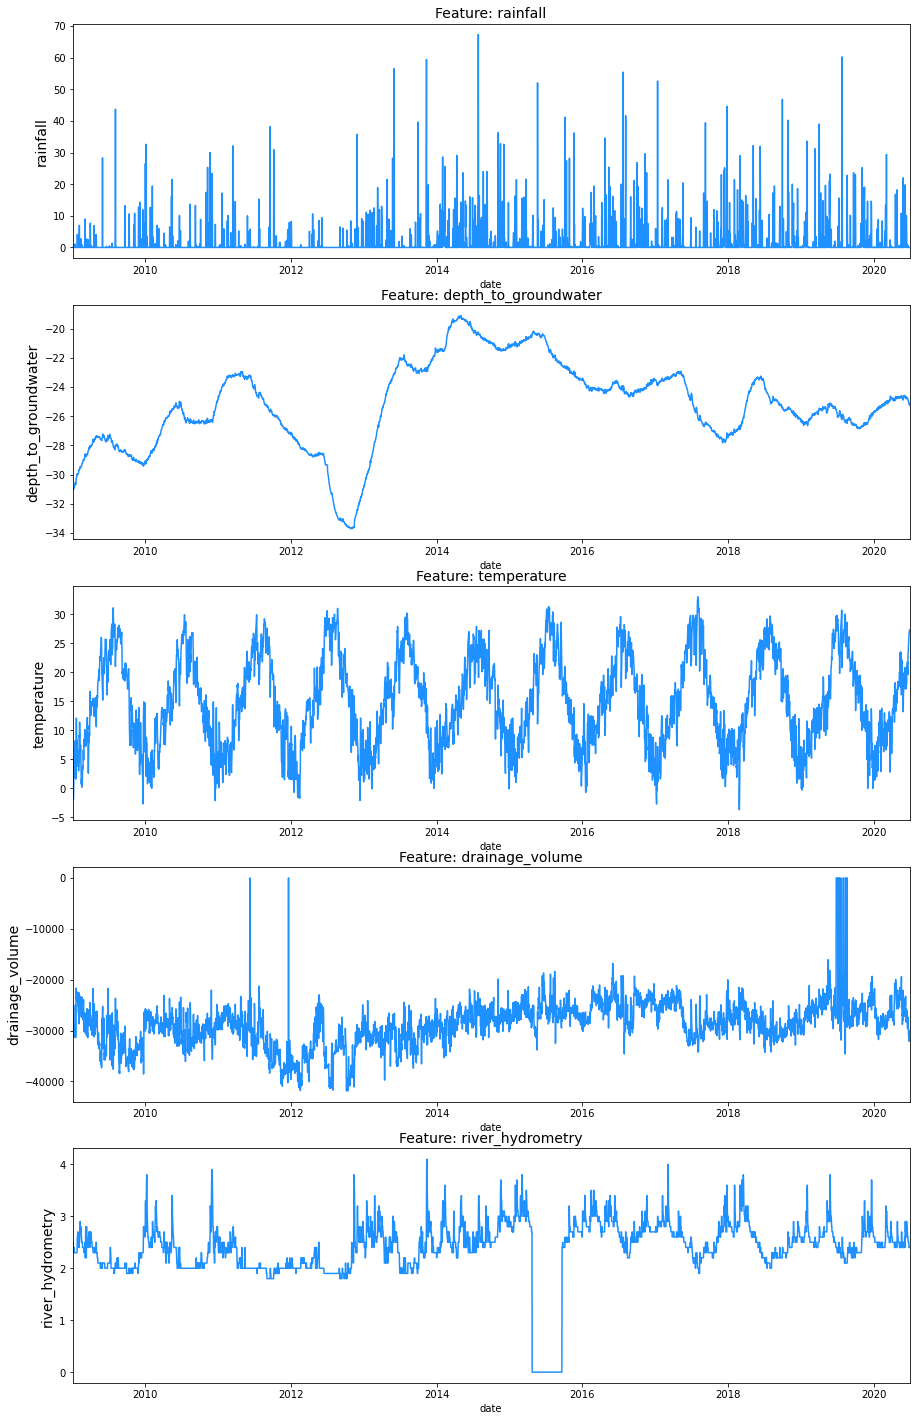

In [6]:
# To complete the data, as naive method, we will use ffill
f, ax = plt.subplots(nrows=5, ncols=1, figsize=(15, 25))

for i, column in enumerate(df.drop('date', axis=1).columns ):
    sns.lineplot(x=df['date'], y=df[column].fillna(method='ffill'), ax=ax[i], color='dodgerblue')
    ax[i].set_title(f'Feature: {column}', fontsize=14)
    ax[i].set_ylabel(ylabel=column, fontsize=14)
    ax[i].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

# Data Preprocessing ⚙️ 

**Chronological Order and Equidistant Timestamps**
The data should be in chronological order and the timestamps should be equidistant in time series. The chronological order can be achieved by sorting the dataframe by the timestamps. Equidisant timestamps indicates constant time intervals. To check this, the difference between each timestamp can be taken. If this is not the case, you can decide on a constant time interval and resample the data.

But, first of all, lets see how to check if our dataset is correctly formated!


In [7]:
df = df.sort_values(by='date')

# Check time intervals
df['delta'] = df['date'] - df['date'].shift(1)

df[['date', 'delta']].head()

,date,delta
0,2009-01-01,NaT
1,2009-01-02,1 days
2,2009-01-03,1 days
3,2009-01-04,1 days
4,2009-01-05,1 days


In [8]:
df['delta'].sum(), df['delta'].count()

(Timedelta('4198 days 00:00:00'), 4198)

## Handle Missings
the dataset has some null values.

Furthermore, plotting the time series reveals that there seem to be **some zero values that seems to be nulls** for ```drainage_volume```, and ```river_hydrometry```. We will have to clean them by replacing them by nan values and filling them afterwards

In [9]:
df = df.drop('delta', axis=1)
df.isna().sum()

date                     0
rainfall                 0
depth_to_groundwater    27
temperature              0
drainage_volume          1
river_hydrometry         0
dtype: int64

(14245.0, 18443.0)

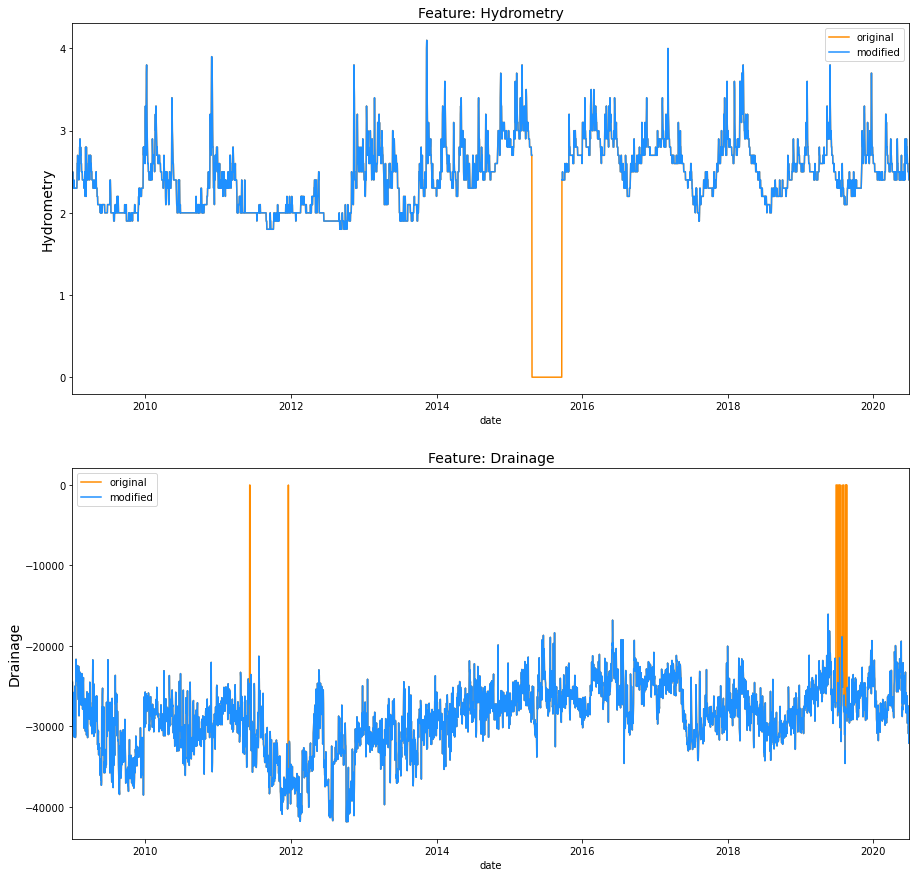

In [10]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 15))

old_hydrometry = df['river_hydrometry'].copy()
df['river_hydrometry'] = df['river_hydrometry'].replace(0, np.nan)

sns.lineplot(x=df['date'], y=old_hydrometry, ax=ax[0], color='darkorange', label='original')
sns.lineplot(x=df['date'], y=df['river_hydrometry'].fillna(np.inf), ax=ax[0], color='dodgerblue', label='modified')
ax[0].set_title('Feature: Hydrometry', fontsize=14)
ax[0].set_ylabel(ylabel='Hydrometry', fontsize=14)
ax[0].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

old_drainage = df['drainage_volume'].copy()
df['drainage_volume'] = df['drainage_volume'].replace(0, np.nan)

sns.lineplot(x=df['date'], y=old_drainage, ax=ax[1], color='darkorange', label='original')
sns.lineplot(x=df['date'], y=df['drainage_volume'].fillna(np.inf), ax=ax[1], color='dodgerblue', label='modified')
ax[1].set_title('Feature: Drainage', fontsize=14)
ax[1].set_ylabel(ylabel='Drainage', fontsize=14)
ax[1].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

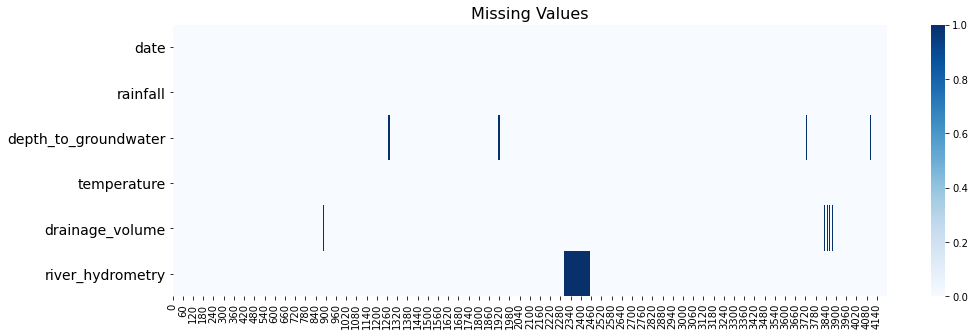

In [11]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 5))

sns.heatmap(df.T.isna(), cmap='Blues')
ax.set_title('Missing Values', fontsize=16)

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
plt.show()

### Missing Values, how to handle
- **Option 1: Fill NaN with Outlier or Zero**

In this specific example filling the missing value with an outlier value such as np.inf or 0 seems to be very naive. However, using values like -999, is sometimes a good idea.

- **Option 2: Fill NaN with Mean Value**

Filling NaNs with the mean value is also not sufficient and naive, and doesn't seems to be a good option.

- **Option 3: Fill NaN with Last Value with .ffill()**

Filling NaNs with the last value could be bit better.

- **Option 4: Fill NaN with Linearly Interpolated Value with .interpolate()**

Filling NaNs with the interpolated values is the best option in this small examlple but it requires knowledge of the neighouring value

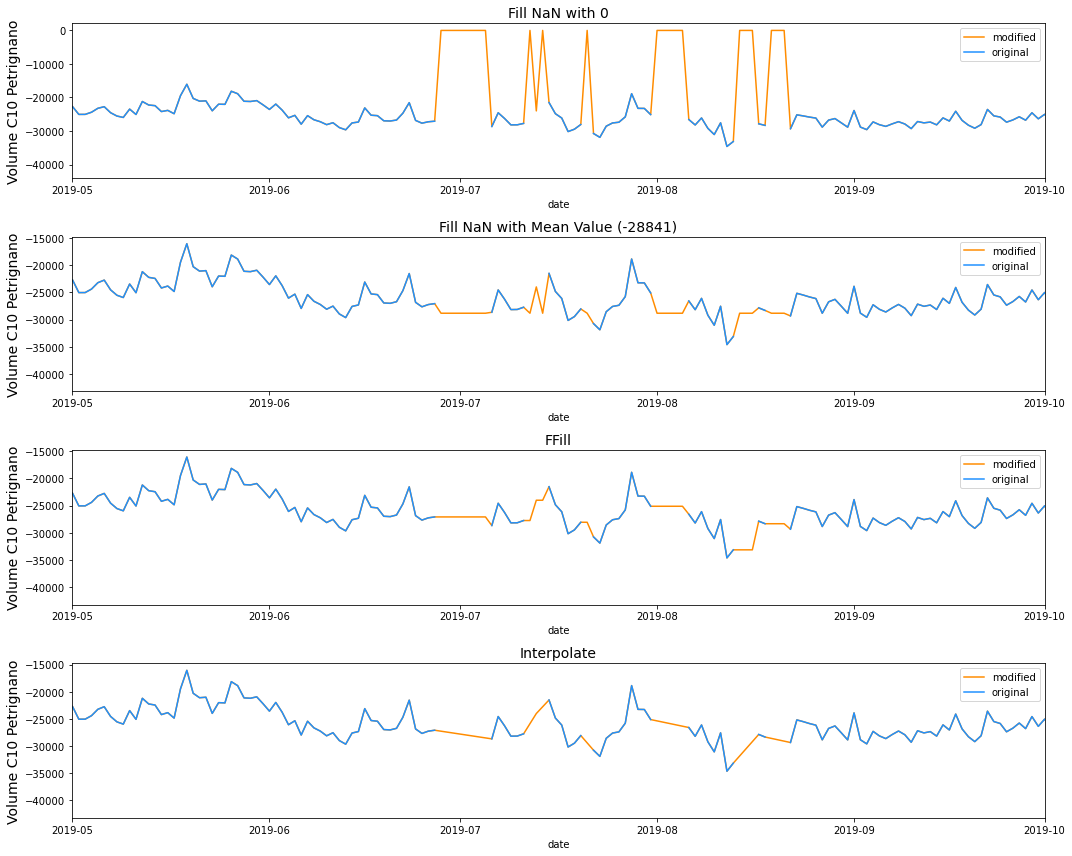

In [12]:
f, ax = plt.subplots(nrows=4, ncols=1, figsize=(15, 12))

sns.lineplot(x=df['date'], y=df['drainage_volume'].fillna(0), ax=ax[0], color='darkorange', label='modified')
sns.lineplot(x=df['date'], y=df['drainage_volume'].fillna(np.inf), ax=ax[0], color='dodgerblue', label='original')
ax[0].set_title('Fill NaN with 0', fontsize=14)
ax[0].set_ylabel(ylabel='Volume C10 Petrignano', fontsize=14)

mean_drainage = df['drainage_volume'].mean()
sns.lineplot(x=df['date'], y=df['drainage_volume'].fillna(mean_drainage), ax=ax[1], color='darkorange', label='modified')
sns.lineplot(x=df['date'], y=df['drainage_volume'].fillna(np.inf), ax=ax[1], color='dodgerblue', label='original')
ax[1].set_title(f'Fill NaN with Mean Value ({mean_drainage:.0f})', fontsize=14)
ax[1].set_ylabel(ylabel='Volume C10 Petrignano', fontsize=14)

sns.lineplot(x=df['date'], y=df['drainage_volume'].ffill(), ax=ax[2], color='darkorange', label='modified')
sns.lineplot(x=df['date'], y=df['drainage_volume'].fillna(np.inf), ax=ax[2], color='dodgerblue', label='original')
ax[2].set_title(f'FFill', fontsize=14)
ax[2].set_ylabel(ylabel='Volume C10 Petrignano', fontsize=14)

sns.lineplot(x=df['date'], y=df['drainage_volume'].interpolate(), ax=ax[3], color='darkorange', label='modified')
sns.lineplot(x=df['date'], y=df['drainage_volume'].fillna(np.inf), ax=ax[3], color='dodgerblue', label='original')
ax[3].set_title(f'Interpolate', fontsize=14)
ax[3].set_ylabel(ylabel='Volume C10 Petrignano', fontsize=14)

for i in range(4):
    ax[i].set_xlim([date(2019, 5, 1), date(2019, 10, 1)])

plt.tight_layout()
plt.show()

In [13]:
df['drainage_volume'] = df['drainage_volume'].interpolate()
df['river_hydrometry'] = df['river_hydrometry'].interpolate()
df['depth_to_groundwater'] = df['depth_to_groundwater'].interpolate()

## Smoothing data / Resampling

Resampling can provide additional information on the data.

There are two types of resampling:

- **Upsampling** is when the frequency of samples is increased (e.g. days to hours)
- **Downsampling** is when the frequency of samples is decreased (e.g. days to weeks)

In this example, we will do some downsampling with the .resample() function (similar to groupby and aggregate as mean).

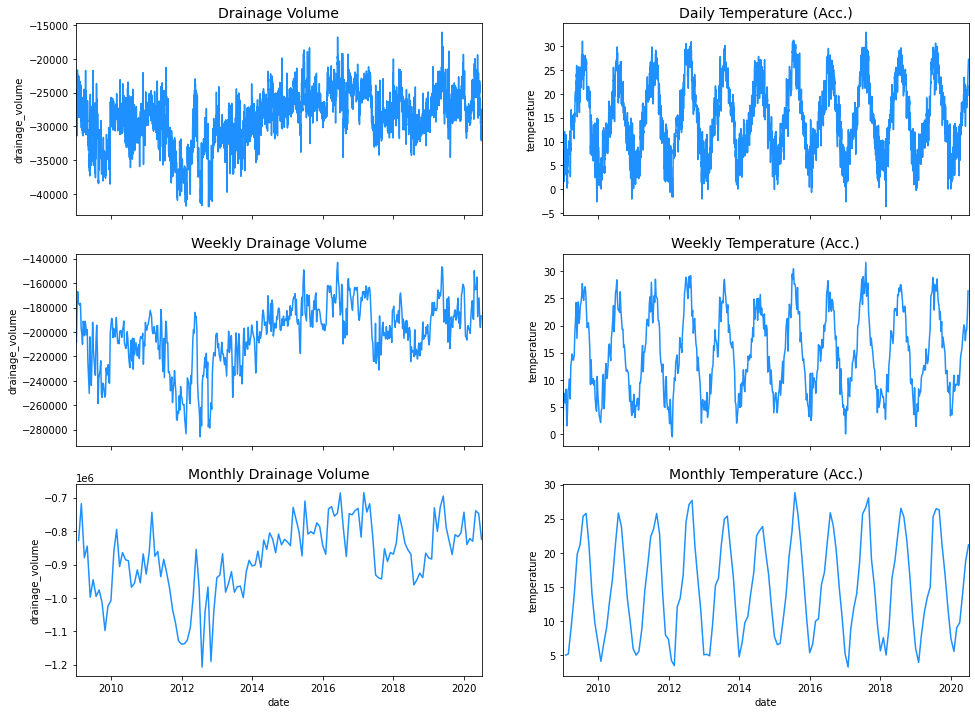

In [14]:
fig, ax = plt.subplots(ncols=2, nrows=3, sharex=True, figsize=(16, 12))

sns.lineplot(df['date'], df['drainage_volume'], color='dodgerblue', ax=ax[0, 0])
ax[0, 0].set_title('Drainage Volume', fontsize=14)

resampled_df = df[['date', 'drainage_volume']].resample('7D', on='date').sum().reset_index(drop=False)
sns.lineplot(resampled_df['date'], resampled_df['drainage_volume'], color='dodgerblue', ax=ax[1, 0])
ax[1, 0].set_title('Weekly Drainage Volume', fontsize=14)

resampled_df = df[['date', 'drainage_volume']].resample('M', on='date').sum().reset_index(drop=False)
sns.lineplot(resampled_df['date'], resampled_df['drainage_volume'], color='dodgerblue', ax=ax[2, 0])
ax[2, 0].set_title('Monthly Drainage Volume', fontsize=14)

for i in range(3):
    ax[i, 0].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])
    
sns.lineplot(df['date'], df['temperature'], color='dodgerblue', ax=ax[0, 1])
ax[0, 1].set_title('Daily Temperature (Acc.)', fontsize=14)

resampled_df = df[['date', 'temperature']].resample('7D', on='date').mean().reset_index(drop=False)
sns.lineplot(resampled_df['date'], resampled_df['temperature'], color='dodgerblue', ax=ax[1, 1])
ax[1, 1].set_title('Weekly Temperature (Acc.)', fontsize=14)

resampled_df = df[['date', 'temperature']].resample(
'M', on='date').mean().reset_index(drop=False)
sns.lineplot(resampled_df['date'], resampled_df['temperature'], color='dodgerblue', ax=ax[2, 1])
ax[2, 1].set_title('Monthly Temperature (Acc.)', fontsize=14)

for i in range(3):
    ax[i, 1].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])
plt.show()

In [15]:
# As we can see, downsample to weekly could smooth the data and help with analysis

downsample = df[['date',
                 'depth_to_groundwater',
                 'temperature',
                 'drainage_volume',
                 'river_hydrometry',
                 'rainfall'
                ]].resample('7D', on='date').mean().reset_index(drop=False)

df = downsample.copy()

## Stationarity
Some time-series models, such as  ARIMA, assume that the underlying data is stationary. 
Stationarity describes that the time-series has

- constant mean and mean is not time-dependent
- constant variance and variance is not time-dependent
- constant covariance and covariance is not time-dependent

![image](https://user-images.githubusercontent.com/37262132/125448519-6b0c00ff-1449-4054-a4f7-58b9fd1c9ef2.png)

The check for stationarity can be done via three different approaches:

1. **visually**: plot time series and check for trends or seasonality
2. **basic statistics**: split time series and compare the mean and variance of each partition
3. **statistical test**: Augmented Dickey Fuller test

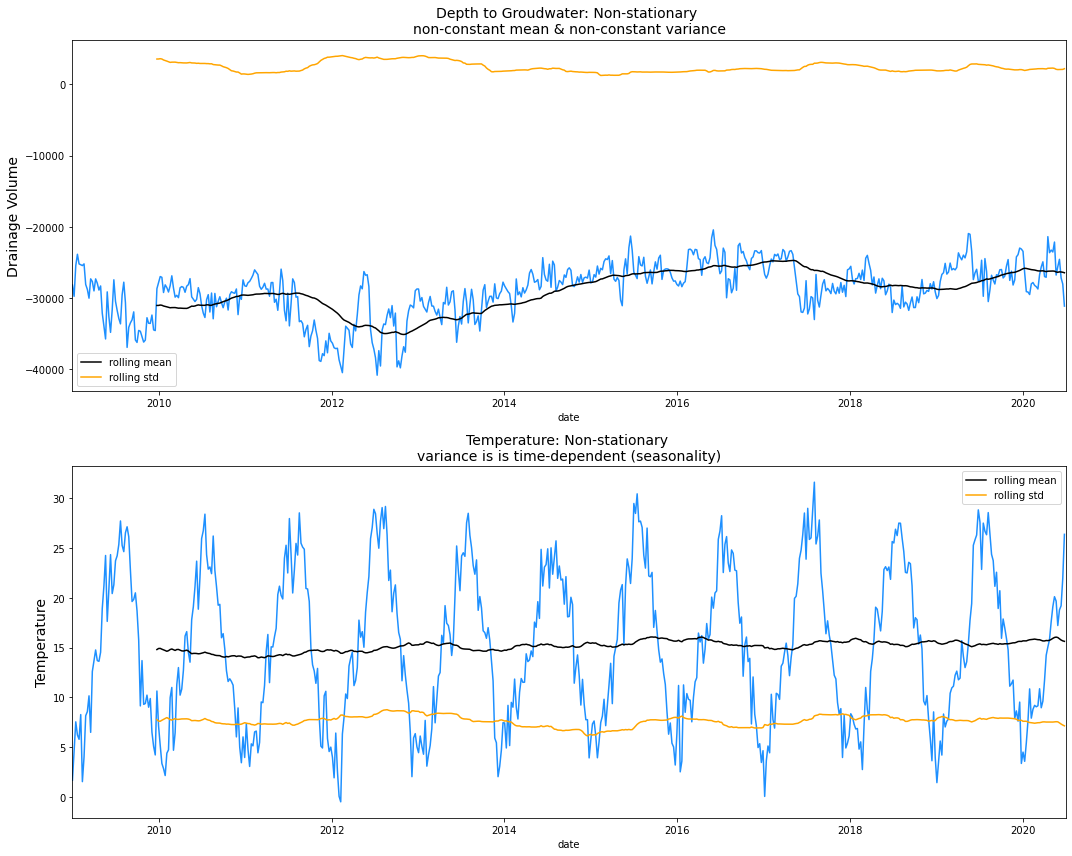

In [16]:
# A year has 52 weeks. (52 weeks * 7 days per week)

rolling_window = 52
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 12))

sns.lineplot(x=df['date'], y=df['drainage_volume'], ax=ax[0], color='dodgerblue')
sns.lineplot(x=df['date'], y=df['drainage_volume'].rolling(rolling_window).mean(), ax=ax[0], color='black', label='rolling mean')
sns.lineplot(x=df['date'], y=df['drainage_volume'].rolling(rolling_window).std(), ax=ax[0], color='orange', label='rolling std')
ax[0].set_title('Depth to Groudwater: Non-stationary \nnon-constant mean & non-constant variance', fontsize=14)
ax[0].set_ylabel(ylabel='Drainage Volume', fontsize=14)
ax[0].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

sns.lineplot(x=df['date'], y=df['temperature'], ax=ax[1], color='dodgerblue')
sns.lineplot(x=df['date'], y=df['temperature'].rolling(rolling_window).mean(), ax=ax[1], color='black', label='rolling mean')
sns.lineplot(x=df['date'], y=df['temperature'].rolling(rolling_window).std(), ax=ax[1], color='orange', label='rolling std')
ax[1].set_title('Temperature: Non-stationary \nvariance is is time-dependent (seasonality)', fontsize=14)
ax[1].set_ylabel(ylabel='Temperature', fontsize=14)
ax[1].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

plt.tight_layout()
plt.show()

**Unit Root Test**

Unit root is a characteristic of a time series that makes it non-stationary. And ADF test belong to the unit root test. Technically , a unit root is said to exist in a time series of value of alpha =1 in below equation.

$Y_t=αY_{t−1}+βX_e+ϵ$
 
where Yt is value of the time series at time ‘t’ and Xe is an exogenous variable .

**The presence of a unit root means the time series is non-stationary.**

### Augmented Dickey-Fuller (ADF)
**Augmented Dickey-Fuller (ADF)** test is a type of statistical test called a unit root test. Unit roots are a cause for non-stationarity.

- **Null Hypothesis (H0)**: Time series has a unit root. (Time series is not stationary).

- **Alternate Hypothesis (H1)**: Time series has no unit root (Time series is stationary).

**If the null hypothesis can be rejected, we can conclude that the time series is stationary.**

There are two ways to rejects the null hypothesis:

On the one hand, the null hypothesis can be rejected if the p-value is below a set significance level. The defaults significance level is 5%

- <span style="color:red">p-value > significance level (default: 0.05)</span>: Fail to reject the null hypothesis (H0), the data has a unit root and is <span style="color:red">non-stationary</span>.
- <span style="color:green">p-value <= significance level (default: 0.05)</span>: Reject the null hypothesis (H0), the data does not have a unit root and is <span style="color:green">stationary</span>.
    
On the other hand, the null hypothesis can be rejects if the test statistic is less than the critical value.

- <span style="color:red">ADF statistic > critical value</span>: Fail to reject the null hypothesis (H0), the data has a unit root and is <span style="color:red">non-stationary</span>.
- <span style="color:green">ADF statistic < critical value</span>: Reject the null hypothesis (H0), the data does not have a unit root and is <span style="color:green">stationary</span>.


In [17]:
# https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['depth_to_groundwater'].values)
result

(-2.880201649316668,
 0.047699190920207926,
 7,
 592,
 {'1%': -3.441444394224128,
  '5%': -2.8664345376276454,
  '10%': -2.569376663737217},
 -734.3154255877625)

Now, we are going to check for each variable:

- The p-value is less than 0.05
- Check the range of the ADF statistic compared with critical_values

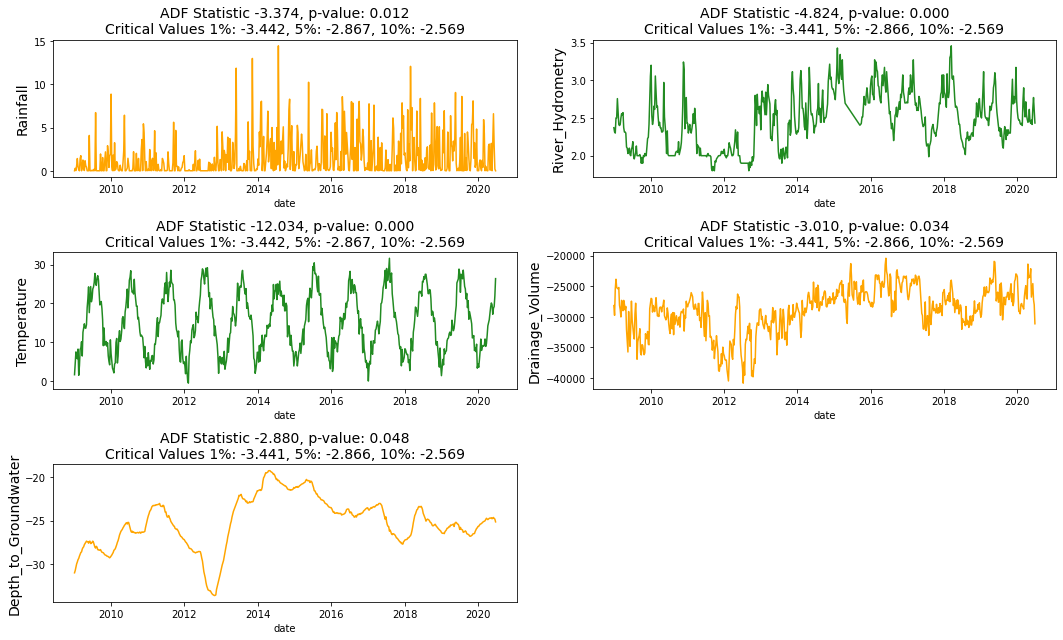

In [22]:
f, ax = plt.subplots(nrows=3, ncols=2, figsize=(15, 9))

def visualize_adfuller_results(series, title, ax):
    result = adfuller(series)
    significance_level = 0.05
    adf_stat = result[0]
    p_val = result[1]
    crit_val_1 = result[4]['1%']
    crit_val_5 = result[4]['5%']
    crit_val_10 = result[4]['10%']
    
    if (p_val < significance_level) & (adf_stat < crit_val_1):
        linecolor = 'forestgreen'
    elif (p_val < significance_level) & (adf_stat < crit_val_5):
        linecolor = 'orange'
    elif (p_val < significance_level) & (adf_stat < crit_val_10):
        linecolor = 'red'
    else:
        linecolor = 'purple'
    sns.lineplot(x=df['date'], y=series, ax=ax, color=linecolor)
    ax.set_title(f'ADF Statistic {adf_stat:0.3f}, p-value: {p_val:0.3f}\nCritical Values 1%: {crit_val_1:0.3f}, 5%: {crit_val_5:0.3f}, 10%: {crit_val_10:0.3f}', fontsize=14)
    ax.set_ylabel(ylabel=title, fontsize=14)
    
visualize_adfuller_results(df['rainfall'].values, 'Rainfall', ax[0, 0])
visualize_adfuller_results(df['temperature'].values, 'Temperature', ax[1, 0])
visualize_adfuller_results(df['river_hydrometry'].values, 'River_Hydrometry', ax[0, 1])
visualize_adfuller_results(df['drainage_volume'].values, 'Drainage_Volume', ax[1, 1])
visualize_adfuller_results(df['depth_to_groundwater'].values, 'Depth_to_Groundwater', ax[2, 0])

f.delaxes(ax[2, 1])
plt.tight_layout()
plt.show()

If the data is not stationary but we want to use a model such as ARIMA (that requires this characteristic), the data has to be transformed.

The two most common methods to transform series into stationarity ones are:

- **Transformation**: e.g. log or square root to stabilize non-constant variance
- **Differencing**: subtracts the current value from the previous

### Transforming

<AxesSubplot:xlabel='depth_to_groundwater_log', ylabel='Density'>

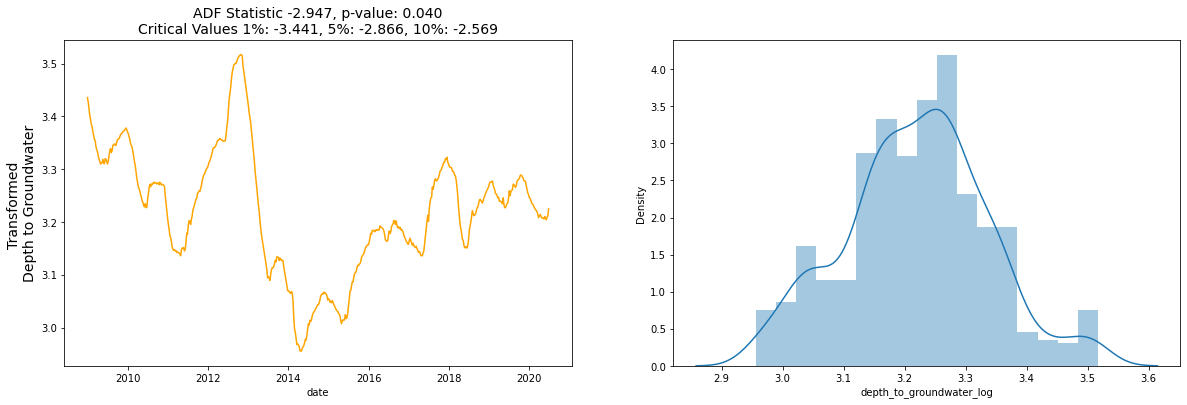

In [27]:
# Log Transform of absolute values
# (Log transoform of negative values will return NaN)
df['depth_to_groundwater_log'] = np.log(abs(df['depth_to_groundwater']))

f, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
visualize_adfuller_results(df['depth_to_groundwater_log'], 'Transformed \nDepth to Groundwater', ax[0])

sns.distplot(df['depth_to_groundwater_log'], ax=ax[1])

Differencing can be done in different orders:

- First order differencing: linear trends with  
$z_i=y_i−y_{i−1}$
 
- Second-order differencing: quadratic trends with  
$z_i=(y_i−y_{i−1})−(y_{i−1}−y_{i−2})$
 
- and so on...

### Differencing

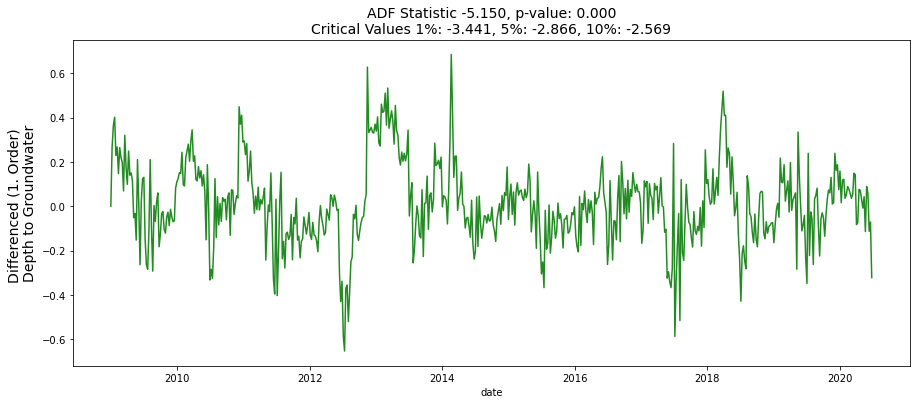

In [26]:
# First Order Differencing
ts_diff = np.diff(df['depth_to_groundwater'])
df['depth_to_groundwater_diff_1'] = np.append([0], ts_diff)

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 6))
visualize_adfuller_results(df['depth_to_groundwater_diff_1'], 'Differenced (1. Order) \nDepth to Groundwater', ax)

# Feature engineering 🔧

In [28]:
df['year'] = pd.DatetimeIndex(df['date']).year
df['month'] = pd.DatetimeIndex(df['date']).month
df['day'] = pd.DatetimeIndex(df['date']).day
df['day_of_year'] = pd.DatetimeIndex(df['date']).dayofyear
df['week_of_year'] = pd.DatetimeIndex(df['date']).weekofyear
df['quarter'] = pd.DatetimeIndex(df['date']).quarter
df['season'] = df['month'] % 12 // 3 + 1

df[['date', 'year', 'month', 'day', 'day_of_year', 'week_of_year', 'quarter', 'season']].head()

,date,year,month,day,day_of_year,week_of_year,quarter,season
0,2009-01-01,2009,1,1,1,1,1,1
1,2009-01-08,2009,1,8,8,2,1,1
2,2009-01-15,2009,1,15,15,3,1,1
3,2009-01-22,2009,1,22,22,4,1,1
4,2009-01-29,2009,1,29,29,5,1,1


## Encoding Cyclical Features
The new time features are cyclical. For example,the feature month cycles between 1 and 12 for every year. While the difference between each month increments by 1 during the year, between two years the month feature jumps from 12 (December) to 1 (January). This results in a -11 difference, which can confuse a lot of models.

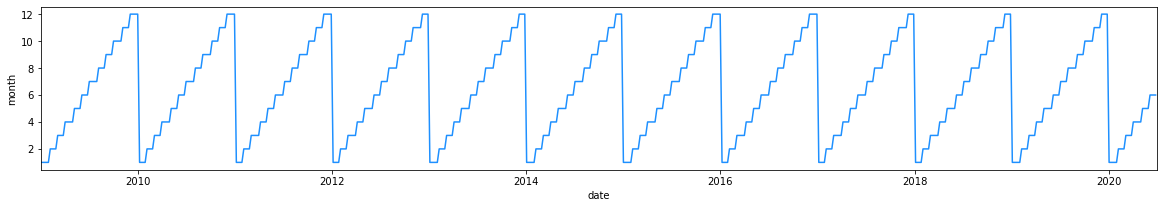

In [29]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 3))

sns.lineplot(x=df['date'], y=df['month'], color='dodgerblue')
ax.set_xlim([date(2009, 1, 1), date(2020, 6, 30)])
plt.show()

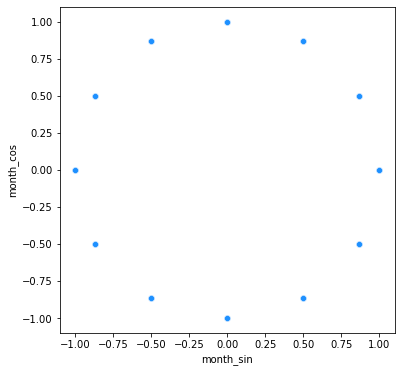

In [30]:
month_in_year = 12
df['month_sin'] = np.sin(2*np.pi*df['month']/month_in_year)
df['month_cos'] = np.cos(2*np.pi*df['month']/month_in_year)

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

sns.scatterplot(x=df.month_sin, y=df.month_cos, color='dodgerblue')
plt.show()

## TimeSeries Decomposition
Time series decomposition involves thinking of a series as a combination of level, trend, seasonality, and noise components.

These components are defined as follows:

- **Level**: The average value in the series.
- **Trend**: The increasing or decreasing value in the series.
- **Seasonality**: The repeating short-term cycle in the series.
- **Noise**: The random variation in the series.
Decomposition provides a useful abstract model for thinking about time series generally and for better understanding problems during time series analysis and forecasting.

All series have a level and noise. The trend and seasonality components are optional.

It is helpful to think of the components as combining either additively or multiplicatively:

- **Additive**: $y(t)=Level+Trend+Seasonality+Noise$
 
- **Multiplicative**: $y(t)=Level∗Trend∗Seasonality∗Noise$
 
In this case we are going to use function ```seasonal_decompose()``` from the statsmodels library.

In [32]:
from statsmodels.tsa.seasonal import seasonal_decompose

core_columns = [
    'rainfall', 'temperature', 'drainage_volume',
    'river_hydrometry', 'depth_to_groundwater'
]

for column in core_columns:
    decomp = seasonal_decompose(df[column], period=52, model='additive', extrapolate_trend='freq')
    df[f'{column}_trend'] = decomp.trend
    df[f'{column}_seasonal'] = decomp.seasonal

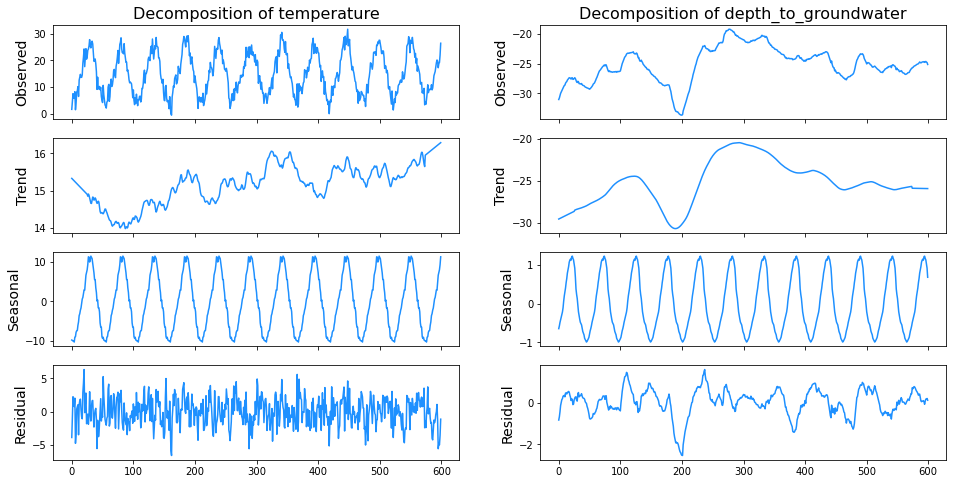

In [33]:
fig, ax = plt.subplots(ncols=2, nrows=4, sharex=True, figsize=(16, 8))

for i, column in enumerate(['temperature', 'depth_to_groundwater']):
    res = seasonal_decompose(df[column], freq=52, model='additive', extrapolate_trend='freq')
    
    ax[0, i].set_title('Decomposition of {}'.format(column), fontsize=16)
    res.observed.plot(ax=ax[0, i], legend=False, color='dodgerblue')
    ax[0, i].set_ylabel('Observed', fontsize=14)
    
    res.trend.plot(ax=ax[1, i], legend=False, color='dodgerblue')
    ax[1, i].set_ylabel('Trend', fontsize=14)
    
    res.seasonal.plot(ax=ax[2, i], legend=False, color='dodgerblue')
    ax[2, i].set_ylabel('Seasonal', fontsize=14)
    
    res.resid.plot(ax=ax[3, i], legend=False, color='dodgerblue')
    ax[3, i].set_ylabel('Residual', fontsize=14)
    
plt.show()

## Lag
We want to calculate each variable with a ```shift()``` (lag) to compare the correlationwith the other variables.

In [34]:
weeks_in_month = 4

for column in core_columns:
    df[f'{column}_seasonal_shift_b_2m'] = df[f'{column}_seasonal'].shift(-2 * weeks_in_month)
    df[f'{column}_seasonal_shift_b_1m'] = df[f'{column}_seasonal'].shift(-1 * weeks_in_month)
    df[f'{column}_seasonal_shift_1m'] = df[f'{column}_seasonal'].shift(1 * weeks_in_month)
    df[f'{column}_seasonal_shift_2m'] = df[f'{column}_seasonal'].shift(2 * weeks_in_month)
    df[f'{column}_seasonal_shift_3m'] = df[f'{column}_seasonal'].shift(3 * weeks_in_month)